# Supervised Learning: Model Training and Evaluation

## Section 1: Classification using logistic regression: build it from the ground up

In [ ]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

### (a) Loading the data

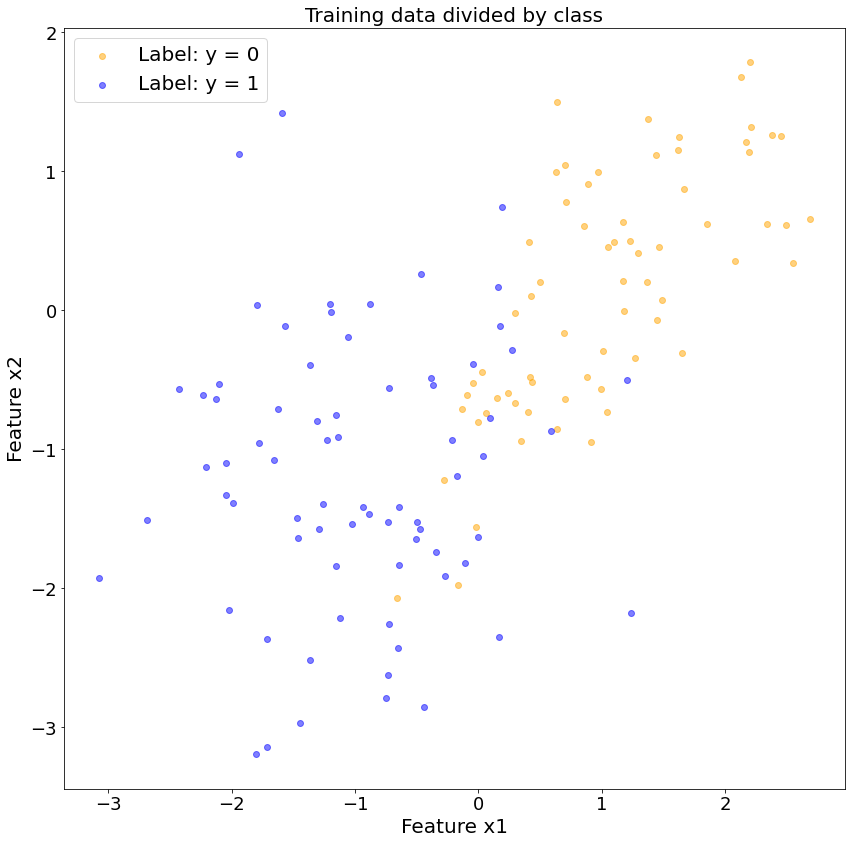

In [ ]:
dataset_full = pd.read_csv("A3_Q1_data.csv")

# Get two NumPy arrays: The first contains features
#.   and the second contains labels
X = dataset_full[["x1", "x2"]].to_numpy()
y = dataset_full["y"].to_numpy()

# Split the data into training (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Transform the four NumPy arrays returned from the function above
#.   into Pandas DataFrames
X_train = pd.DataFrame(data=X_train, columns=["x1", "x2"])
X_test = pd.DataFrame(data=X_test, columns=["x1", "x2"])
y_train = pd.DataFrame(data=y_train, columns=["y"])
y_test = pd.DataFrame(data=y_test, columns=["y"])

# Pair feature vectors with their corresponding labels
Xy_train = pd.concat([X_train, y_train], axis=1)
Xy_test = pd.concat([X_test, y_test], axis=1)

# Split up training data by class
Xy_train_class_0 = Xy_train[Xy_train["y"] == 0]
Xy_train_class_1 = Xy_train[Xy_train["y"] == 1]

# Plot training data
plt.figure(figsize=(14, 14))
plt.title("Training data divided by class", fontsize=20)
plt.xlabel("Feature x1", fontsize=20)
plt.ylabel("Feature x2", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.scatter(Xy_train_class_0["x1"], Xy_train_class_0["x2"],
            color="orange", alpha=0.5, label="Label: y = 0")
plt.scatter(Xy_train_class_1["x1"], Xy_train_class_1["x2"],
            color="blue", alpha=0.5, label="Label: y = 1")
plt.legend(prop = {"size":(20)})
plt.show()

<font size="4">The data are not linearly separable in the current feature space. We would have to do some feature engineering to obtain linearly separable data (e.g. project the data into a higher-dimensional space). That said, the decision boundary is approximately linear, and our training sample size is modest (n = 140), so a less flexible classification algorithm is preferable (i.e. of the models we've learned in class so far, we want to use logistic regression or LDA instead of a more flexible method like KNN or QDA).

How should we decide between LDA and logistic regression? LDA assumes that the data for each class are normally distributed, which implies that logistic regression will tend to outperform LDA in scenarios where the training data for at least one class are far from normally distributed. To determine whether or not this is the case for this data, we could create 3D surface plots of the data for each class (similar to figure 4.5 in ISL). But for the purposes of this assignment, we know that logistic regression should perform reasonably well, so we'll proceed with logistic regression.

### (b) Preprocessing

<font size="4">As the first step of preprocessing, let's see if there are any missing values in either the training or test set.

<Figure size 1080x648 with 0 Axes>

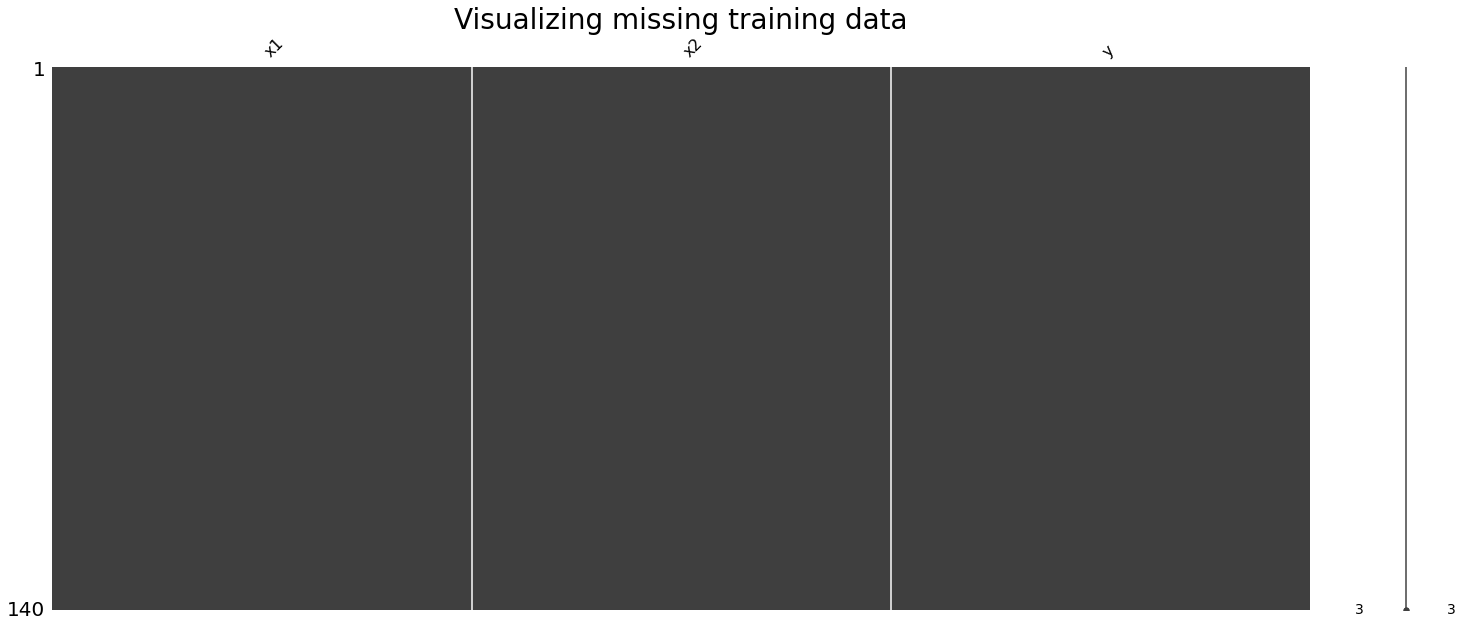

<Figure size 1080x648 with 0 Axes>

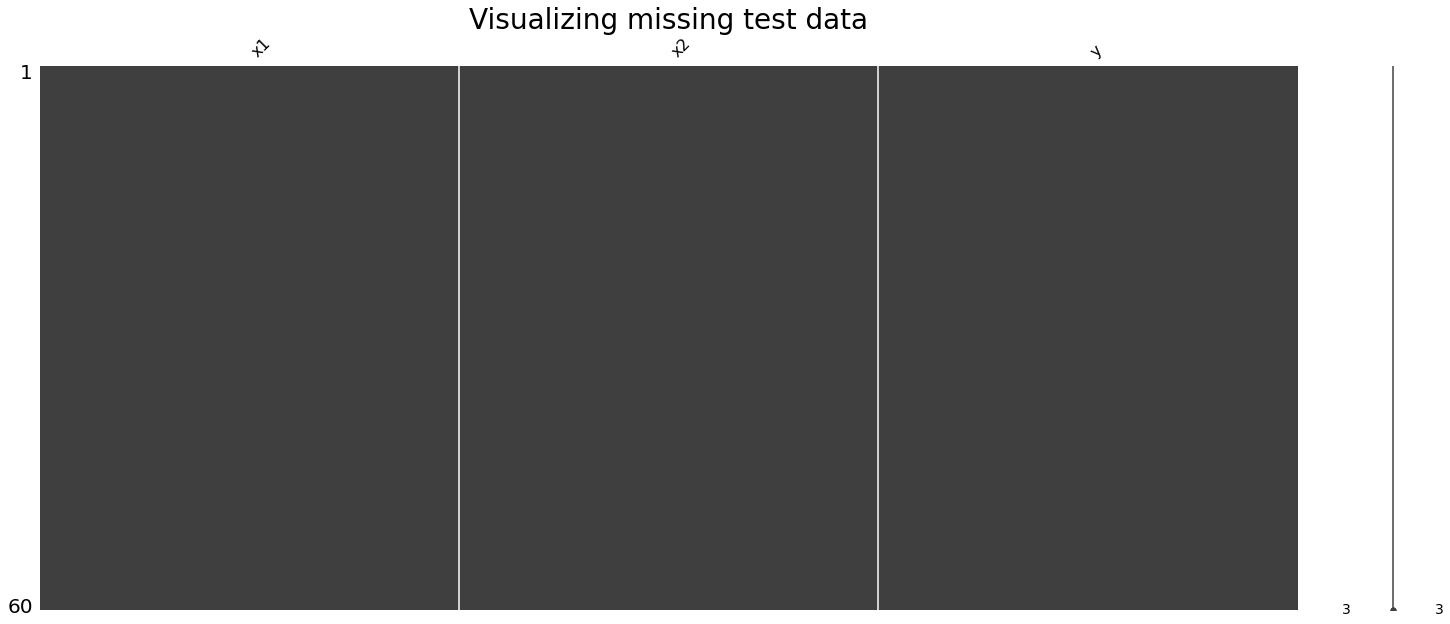

In [ ]:
import missingno as msno

plt.figure(figsize=(15, 9))
msno.matrix(Xy_train)
plt.title("Visualizing missing training data", fontsize=28)
plt.show()

plt.figure(figsize=(15, 9))
msno.matrix(Xy_test)
plt.title("Visualizing missing test data", fontsize=28)
plt.show()

<font size="4">The figures above allow us to visualize missing values in the training and test data. There are no missing values, because all three bars are fully shaded in for each of the two plots.

<font size="4">Second step of preprocessing: Let's see if feature x1 is measured using a very different scale from feature x2.

In [ ]:
Xy_train.describe()

,x1,x2,y
count,140.000000,140.000000,140.000000
mean,-0.018489,-0.552399,0.521429
std,1.317404,1.139200,0.501334
min,-3.072983,-3.193456,0.000000
25%,-1.126014,-1.415669,0.000000
50%,-0.004914,-0.564990,1.000000
75%,0.996589,0.280502,1.000000
max,2.685322,1.783620,1.000000


In [ ]:
x1_max = round(Xy_train["x1"].max(), 3)
x1_min = round(Xy_train["x1"].min(), 3)
x2_max = round(Xy_train["x2"].max(), 3)
x2_min = round(Xy_train["x2"].min(), 3)

print(f"The training range of feature x1 is [{x1_min}, {x1_max}], \
and the range for x2 is [{x2_min}, {x2_max}]. \
These are similar, so we don't need to do anything to address range discrepancies.")

The training range of feature x1 is [-3.073, 2.685], and the range for x2 is [-3.193, 1.784]. These are similar, so we don't need to do anything to address range discrepancies.


<font size="4">As a final preprocessing step, let's see if there are any outliers. We'll use the 1.5 * IQR rule for determining outliers.

In [ ]:
train_x1_min = round(Xy_train["x1"].min(), 3)
train_x1_max = round(Xy_train["x1"].max(), 3)
train_x2_min = round(Xy_train["x2"].min(), 3)
train_x2_max = round(Xy_train["x2"].max(), 3)

# Calculate the interquartile range for both x1 and x2 in the training set
train_x1_q1 = np.quantile(Xy_train["x1"], 0.25)
train_x1_q3 = np.quantile(Xy_train["x1"], 0.75)
train_x2_q1 = np.quantile(Xy_train["x2"], 0.25)
train_x2_q3 = np.quantile(Xy_train["x2"], 0.75)

train_x1_IQR = train_x1_q3 - train_x1_q1
train_x2_IQR = train_x2_q3 - train_x2_q1

# The lower bound for outliers will be the first quartile minus 1.5 * IQR
# The upper bound will be the third quartile plus 1.5 * IQR
train_x1_lower_bound = round(train_x1_q1 - (1.5 * train_x1_IQR), 3)
train_x1_upper_bound = round(train_x1_q3 + (1.5 * train_x1_IQR), 3)
train_x2_lower_bound = round(train_x2_q1 - (1.5 * train_x2_IQR), 3)
train_x2_upper_bound = round(train_x2_q3 + (1.5 * train_x2_IQR), 3)

print(f"If any values of x1 fall outside of [{train_x1_lower_bound}, {train_x1_upper_bound}], \
that datapoint will be considered an outlier.")
print()
print(f"If any values of x2 fall outside of [{train_x2_lower_bound}, {train_x2_upper_bound}], \
that datapoint will be considered an outlier.")
print()
print(f"In both cases, there are no outliers, because all training values of x1 lie in, \
[{train_x1_min}, {train_x1_max}], and all training values of x2 lie in [{train_x2_min}, {train_x2_max}].")
print()
print(f"Now let's repeat the process and check for outliers in the test set.")

If any values of x1 fall outside of [-4.31, 4.18], that datapoint will be considered an outlier.

If any values of x2 fall outside of [-3.96, 2.825], that datapoint will be considered an outlier.

In both cases, there are no outliers, because all training values of x1 lie in, [-3.073, 2.685], and all training values of x2 lie in [-3.193, 1.784].

Now let's repeat the process and check for outliers in the test set.


In [ ]:
test_x1_min = round(Xy_test["x1"].min(), 3)
test_x1_max = round(Xy_test["x1"].max(), 3)
test_x2_min = round(Xy_test["x2"].min(), 3)
test_x2_max = round(Xy_test["x2"].max(), 3)

test_x1_q1 = np.quantile(Xy_test["x1"], 0.25)
test_x1_q3 = np.quantile(Xy_test["x1"], 0.75)
test_x2_q1 = np.quantile(Xy_test["x2"], 0.25)
test_x2_q3 = np.quantile(Xy_test["x2"], 0.75)

test_x1_IQR = test_x1_q3 - test_x1_q1
test_x2_IQR = test_x2_q3 - test_x2_q1

test_x1_lower_bound = round(test_x1_q1 - (1.5 * test_x1_IQR), 3)
test_x1_upper_bound = round(test_x1_q3 + (1.5 * test_x1_IQR), 3)
test_x2_lower_bound = round(test_x2_q1 - (1.5 * test_x2_IQR), 3)
test_x2_upper_bound = round(test_x2_q3 + (1.5 * test_x2_IQR), 3)

print(f"If any values of x1 fall outside of [{test_x1_lower_bound}, {test_x1_upper_bound}], \
that datapoint will be considered an outlier.")
print()
print(f"If any values of x2 fall outside of [{test_x2_lower_bound}, {test_x2_upper_bound}], \
that datapoint will be considered an outlier.")
print()
print(f"In both cases, there are no outliers, because all test values of x1 lie in, \
[{test_x1_min}, {test_x1_max}], and all test values of x2 lie in\n[{test_x2_min}, {test_x2_max}].")

If any values of x1 fall outside of [-3.579, 5.046], that datapoint will be considered an outlier.

If any values of x2 fall outside of [-3.554, 3.592], that datapoint will be considered an outlier.

In both cases, there are no outliers, because all test values of x1 lie in, [-3.21, 3.868], and all test values of x2 lie in
[-2.37, 3.104].


### (c) Defining the likelihood function for the entire dataset

<font size="4">For a single observation $(\mathbf{x}_i, y_i)$, the likelihood of the parameters is given by

\begin{equation*}
L(\mathbf{w} | \mathbf{x}_i, y_i) = P(y_i = 1 | \mathbf{x}_i)^{y_i} \, P(y_i = 0 | \mathbf{x}_i)^{1-y_i}
\end{equation*}

So it follows that for N observations, the likelihood of the parameters is given by

\begin{align*}
L(\mathbf{w} | \mathbf{y}, \mathbf{X}) &= \prod_{i=1}^{N} P(y_i = 1 | \mathbf{x}_i)^{y_i} \, P(y_i = 0 | \mathbf{x}_i)^{1-y_i}\\
&= \prod_{i=1}^{N} \sigma(\mathbf{w}^T\mathbf{x}_i)^{y_i}(1 - \sigma(\mathbf{w}^T\mathbf{x}_i))^{1-y_i}
\end{align*}

### (d) Defining the cross entropy loss function

Write $\hat{y}_i = \sigma(\mathbf{w}^T \mathbf{x}_i)$. Then

\begin{align*}
\text{log}(L(\mathbf{w} | \mathbf{y}, \mathbf{X})) &= \text{log}\left(\prod_{i=1}^{N} \hat{y}_i^{y_i}(1-\hat{y}_i)^{1-y_i}\right)\\
&= \sum_{i=1}^{N} \text{log}(\hat{y}_i^{y_i}(1-\hat{y}_i)^{1-y_i})\\
&= \sum_{i=1}^{N} y_i \text{log}(\hat{y}_i) + (1 - y_i) \text{log}(1- \hat{y}_i)
\end{align*}

So our normalized cost function, known as the *cross entropy* cost function is given by

\begin{equation*}
C(\mathbf{w}) = -\frac{1}{N}\sum_{i=1}^{N} y_i \text{log}(\hat{y}_i) + (1 - y_i) \text{log}(1- \hat{y}_i))
\end{equation*}

### (e) Okay, buckle up! Time to calculate a fairly gnarly gradient :)

<font size="4">
\begin{align*}
\nabla C(\mathbf{w}) &= \nabla \left[-\frac{1}{N}\sum_{i=1}^{N} y_i \text{log}(\hat{y}_i) + (1 - y_i) \text{log}(1- \hat{y}_i))\right] \\
&= -\frac{1}{N} \sum_{i=1}^{N} \nabla \left[ y_i \text{log}(\hat{y}_i) + (1 - y_i) \text{log}(1- \hat{y}_i) \right]\\
&= -\frac{1}{N} \sum_{i=1}^{N} \left[ \frac{y_i}{\sigma(\mathbf{w}^T x_i)} \sigma(\mathbf{w}^Tx_i)\sigma(-\mathbf{w}^Tx_i) \nabla[\mathbf{w}^Tx_i]  + \frac{1-y_i}{\sigma(-\mathbf{w}^Tx_i)}\sigma(-\mathbf{w}^Tx_i)\sigma(\mathbf{w}^Tx_i) \nabla [-\mathbf{w}^Tx_i]\right]\\
&= -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \sigma(-\mathbf{w}^Tx_i) \nabla[\mathbf{w}^Tx_i] + (1-y_i)\sigma(\mathbf{w}^Tx_i) \nabla[-\mathbf{w}^Tx_i] \right]\\
&= -\frac{1}{N} \sum_{i=1}^{N} \nabla[\mathbf{w}^Tx_i] (y_i \sigma(-\mathbf{w}^Tx_i) - \sigma(\mathbf{w}^Tx_i) +y_i\sigma(\mathbf{w}^Tx_i))\\
&= -\frac{1}{N} \sum_{i=1}^{N} \nabla[\mathbf{w}^Tx_i] (y_i (1 - \sigma(\mathbf{w}^Tx_i)) - \sigma(\mathbf{w}^Tx_i) +y_i\sigma(\mathbf{w}^Tx_i))\\
&= -\frac{1}{N} \sum_{i=1}^{N} \nabla[\mathbf{w}^Tx_i] (y_i - \sigma(\mathbf{w}^Tx_i))\\
&= -\frac{1}{N} \sum_{i=1}^{N} \nabla [w_0x_{i,0} + w_1x_{i,1} + w_2x_{i,2}](y_i - \sigma(\mathbf{w}^Tx_i))\\
&= -\frac{1}{N} \sum_{i=1}^{N} [x_{i,0}, x_{i,1}, x_{i,2}](y_i - \sigma(\mathbf{w}^Tx_i))\\
&= -\frac{1}{N} \sum_{i=1}^{N} [1, x_{i,1}, x_{i,2}](y_i - \sigma(\mathbf{w}^Tx_i))\\
&= -\frac{1}{N} \sum_{i=1}^{N} \left[ (y_i - \sigma(\mathbf{w}^Tx_i)), (x_{i, 1}(y_i - \sigma(\mathbf{w}^Tx_i)), (x_{i, 2}(y_i - \sigma(\mathbf{w}^Tx_i)) \right]\\
&= \left[ -\frac{1}{N} \sum_{i=1}^{N}y_i - \sigma(\mathbf{w}^Tx_i), -\frac{1}{N} \sum_{i=1}^{N}x_{i, 1}(y_i - \sigma(\mathbf{w}^Tx_i), -\frac{1}{N} \sum_{i=1}^{N}x_{i, 2}(y_i - \sigma(\mathbf{w}^Tx_i) \right]\\
&= \left[ \frac{\partial C}{\partial w_0}, \frac{\partial C}{\partial w_1}, \frac{\partial C}{\partial w_2} \right]
\end{align*}

### (f) The gradient descent update equation for logistic regression

<font size="4">
\begin{align*}
\mathbf{w}^{(k+1)} &= \left[ w_0^{(k+1)}, w_1^{(k+1)}, w_2^{(k+1)}\right]\\
&= \left[ w_0^{(k)} - \eta \frac{\partial C(w_0^{(k)})}{\partial w_0}, w_1^{(k)} - \eta \frac{\partial C(w_1^{(k)})}{\partial w_1}, w_2^{(k)} - \eta \frac{\partial C(w_2^{(k)})}{\partial w_2}\right]\\
&= \mathbf{w}^{(k)} - \eta \nabla C(\mathbf{w^{(k)}})
\end{align*}

### (g) Logistic regression from scratch

In [ ]:
class Logistic_regression:
    """This class allows us to fit a logistic regression model to
       training data with two features (plus a bias term) and
       make predictions on test data
    """
    
    def __init__(self):
        """Construct a new Logistic_regression object by initializing
           the weights to random numbers in [0, 1)"""
        self.w = np.random.rand(3)     
        self.saved_w = [self.w] 
                          
                          
    
    def sigmoid(self, X, w):
        """Takes each row x of X, computes standard inner product <x, w>,
           and passes result through the sigmoid activation function
        
        Parameters
        ----------
        X: ndarray
            (n x 3) matrix of samples
            
        w: ndarray
            (1 x 3) array of weights
        
        Returns
        ----------
        (n x 1) array containing the result of the operation
        """
        
        wTx = X @ w.reshape(1, -1).T
        return 1 / (1 + np.exp(-wTx))
    
    def cost(self, X, y, w):
        """Computes the cross-entropy loss for an entire
        matrix of labeled observations
        
        Parameters
        ----------
        X: ndarray
            (n x 3) matrix of observations
            
        y: ndarray
            (n x 1) array of labels for each observation in X
        
        w: ndarray
            (1 x 3) array of weights
        
        Returns
        ----------
        The average cross-entropy loss that results from
        predicting the labels of each observation in X using
        w as weights
        """
        
        N = len(X)
        y_hat = self.sigmoid(X, w)
        c_total = np.sum((y * np.log(y_hat)) + ((1 - y) * np.log(1 - y_hat)))
        c_avg = (-1 / N) * c_total
        return c_avg
    
    def gradient_descent(self, X, y, lr):
        """Execute one step of gradient descent
        Update the array of saved weights as well as the set of current weights
        
        
        Parameters
        ----------
        X: ndarray
            (n x 3) matrix of observations
            
        y: ndarray
            (n x 1) array of labels for each observation in X
            
        lr: double
            learning rate - a hyperparameter of the logistic regression algorithm
        
        Returns
        ----------
        A scalar representing the Euclidean norm of the change in weights
        after one step of gradient descent
        """

        w_curr = self.w
        y_hat = self.sigmoid(X, w_curr)
        err = y - y_hat
        N = len(X)
        gradient = (-1/N) * np.sum(X * err, axis=0)
        w_next = w_curr - (lr * gradient)
        self.w = w_next
        self.saved_w.append(w_next)
        return np.sqrt(np.sum((w_curr - w_next) ** 2))
    
    def fit(self, X, y, w_init, lr, delta_thresh=1e-6, max_iter=5000, verbose=False):
        """Fit a linear regression model to a set of observations
        using gradient descent on cross-entropy loss
        
        Parameters
        ----------
        X: ndarray
            (n x 3) matrix of observations that we will fit a linear regression model to
        
        y: ndaray
            (n x 1) array of labels for each observation in X
        
        w_init: ndarray
            (1 x 3) array of initial weights
            When we call this method, w_init will usually be a random vector
            
        lr: double
            learning rate - a hyperparameter of the logistic regression algorithm
        
        delta_thresh: double
            The fitting process will terminate if the change in the norm of the difference
            between weight vectors in two successive iterations of gradient descent
            falls below this threshold
        
        max_iter: int
            The fitting process will terminate if the number of iterations of gradient
            descent surpasses this threshold
        
        verbose: bool
            If True, this method will print the weights at each iteration of gradient descent
        
        Returns
        ----------
        Nothing
        """

        self.w = w_init
        self.saved_w = [w_init]
        num_iter = 0
        while (num_iter <= max_iter):
            delta = self.gradient_descent(X, y, lr)
            if delta < delta_thresh:
                break
            num_iter += 1
    
    def predict_proba(self, X):
        """Use a trained model to predict confidence scores (posterior probability of positive class)
        
        Parameters
        ----------
        X: ndarray
            (n x 3) matric of observations that we want to predict a confidence score for
        
        Returns
        ----------
        (n x 1) array of confidence scores
        
        """
        
        return self.sigmoid(X, self.w.reshape(1, -1).T)
    
    def predict(self, X, thresh=0.5):
        """Use a trained model to classify observations into either class 0 or class 1
        
        Parameters
        ----------
        X: ndarray
            (n x 3) matrix of observations we want to do binary classification on
        
        thresh: double
            if the model's confidence score is lower than thresh, classify as class 0,
            otherwise classify as class 1
        
        Returns
        ----------
        (n x 1) array of binary predictions
        """
        
        predictions = self.predict_proba(X)
        for i in range(len(predictions)):
            if predictions[i] < thresh:
                predictions[i] = 0
            else:
                predictions[i] = 1
        return predictions
    
    def learning_curve(self, X, y):
        """Get the costs associated with each step of gradient descent
        A helpful method if we want to plot learning curves
        Call this method after the model has been trained
        
        Parameters
        ----------
        X: ndarray
            (n x 3) array of observations
        
        y: ndarray
            (n x 1) array of labels for each observation in X
        
        Returns
        ----------
        An ordered list of costs associated with each step of the learning process
        """

        costs = []
        for w in self.saved_w:
            costs.append(self.cost(X, y, w))
        return costs
    
    def prepare_x(self, X):
        """Attach a column of ones as the first column of an array of observations
        Accounts for the bias term
        Don't call this method within the definition of this class
        Only call this method when writing code outside of this class
        
        Parameters
        ----------
        X: ndarray
            (n x 3) array of observations
        
        Returns
        ----------
        X with a leading column of ones
        Effectively creates a new feature x_0 that is always equal to 1
        """
        
        ones = np.ones(X.shape[0]).reshape(-1, 1)
        X_new = np.concatenate([ones, X], axis=1)
        return X_new
    
    def reset(self):
        """Untrain the model by resetting the weights randomly and clearing
        the list of saved weights
        """
        
        self.w = np.random.rand(3)
        self.saved_w = [self.w]

### (h) Fitting the linear regression model and comparing learning rates

In [ ]:
lr_slow = 10e-4
lr_med = 10e-2
lr_fast = 1

log_reg_slow = Logistic_regression()
log_reg_med = Logistic_regression()
log_reg_fast = Logistic_regression()

# Append a column of ones to the beginning of the training and test sets
X_train_prepped = log_reg_slow.prepare_x(X_train)
X_test_prepped = log_reg_slow.prepare_x(X_test)

# Fit a slow, medium, and fast-learning model to the training set
log_reg_slow.fit(X_train_prepped, y_train.to_numpy(), np.random.rand(3), lr_slow)
log_reg_med.fit(X_train_prepped, y_train.to_numpy(), np.random.rand(3), lr_med)
log_reg_fast.fit(X_train_prepped, y_train.to_numpy(), np.random.rand(3), lr_fast)

# Get the training costs for each iteration of gradient descent for each model
costs_train_slow = log_reg_slow.learning_curve(X_train_prepped, y_train.to_numpy())
costs_train_med = log_reg_med.learning_curve(X_train_prepped, y_train.to_numpy())
costs_train_fast = log_reg_fast.learning_curve(X_train_prepped, y_train.to_numpy())

# Get the test costs for each iteration of gradient descent for each model
costs_test_slow = log_reg_slow.learning_curve(X_test_prepped, y_test.to_numpy())
costs_test_med = log_reg_med.learning_curve(X_test_prepped, y_test.to_numpy())
costs_test_fast = log_reg_fast.learning_curve(X_test_prepped, y_test.to_numpy())

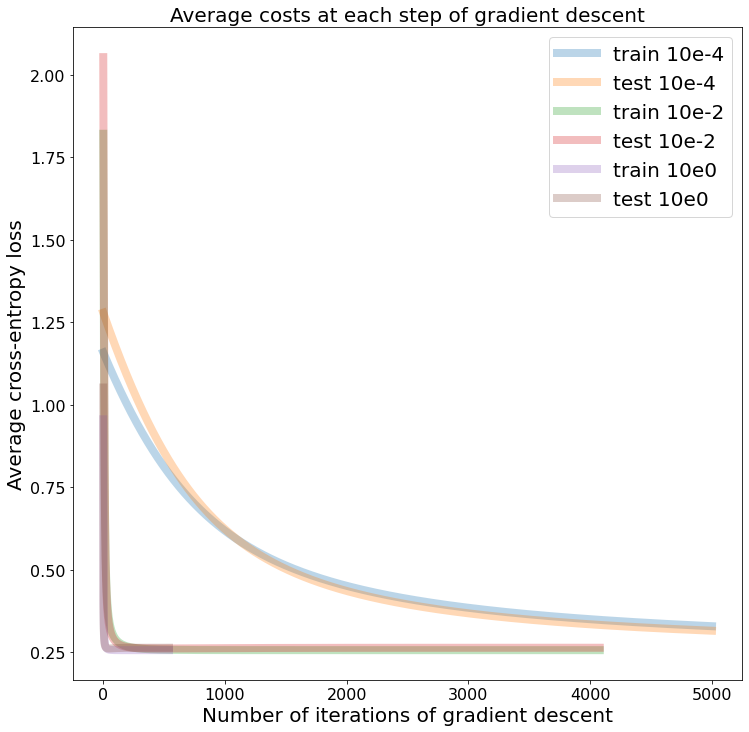

In [ ]:
plt.figure(figsize=(12, 12))
plt.plot(np.arange(len(costs_train_slow)), costs_train_slow,
         label="train 10e-4", linewidth=8, alpha=0.3)
plt.plot(np.arange(len(costs_test_slow)), costs_test_slow,
         label="test 10e-4", linewidth=8, alpha=0.3)
plt.plot(np.arange(len(costs_train_med)), costs_train_med,
         label="train 10e-2", linewidth=8, alpha=0.3)
plt.plot(np.arange(len(costs_test_med)), costs_test_med,
         label="test 10e-2", linewidth=8, alpha=0.3)
plt.plot(np.arange(len(costs_train_fast)), costs_train_fast,
         label="train 10e0", linewidth=8, alpha=0.3)
plt.plot(np.arange(len(costs_test_fast)), costs_test_fast,
         label="test 10e0", linewidth=8, alpha=0.3)
plt.title("Average costs at each step of gradient descent", fontsize=20)
plt.xlabel("Number of iterations of gradient descent", fontsize=20)
plt.ylabel("Average cross-entropy loss", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(prop={"size":20})
plt.show()

In [ ]:
# What happens with a really big learning rate?

lr_super_fast = 100
log_reg_super_fast = Logistic_regression()
log_reg_super_fast.fit(X_train_prepped, y_train.to_numpy(), np.random.rand(3), lr_super_fast)

weights_super_fast = np.array(log_reg_super_fast.saved_w[0:50])
weights_fast = np.array(log_reg_fast.saved_w[0:50])

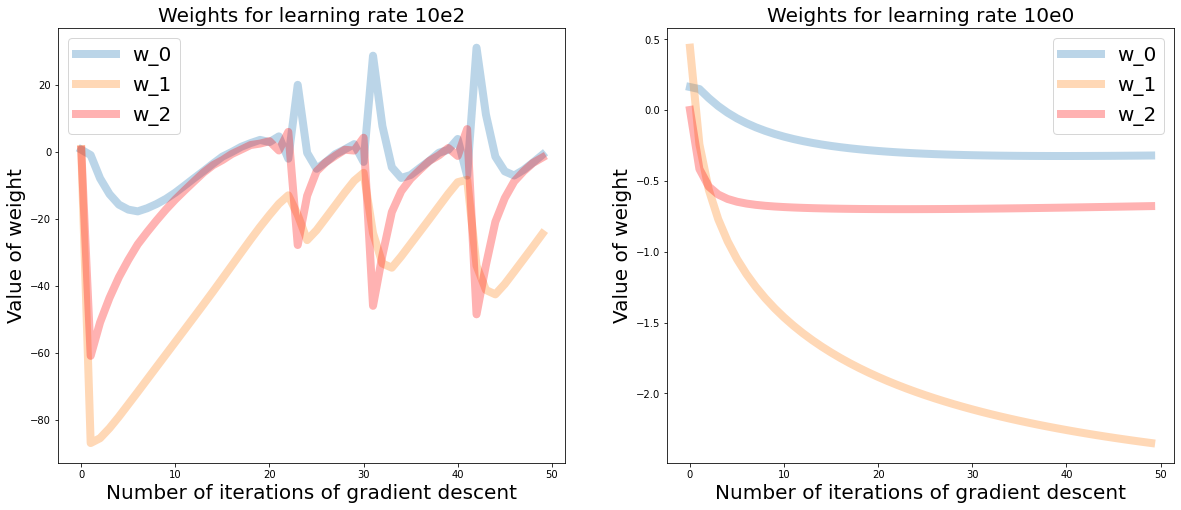

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

ax[0].plot(np.arange(50), weights_super_fast[:,0], label = "w_0", linewidth=8, alpha=0.3)
ax[0].plot(np.arange(50), weights_super_fast[:,1], label = "w_1", linewidth=8, alpha=0.3)
ax[0].plot(np.arange(50), weights_super_fast[:,2], label = "w_2", linewidth=8, alpha=0.3, color='r')
ax[0].legend(prop = {"size": 20})
ax[0].set_title("Weights for learning rate 10e2", fontsize=20)
ax[0].set_xlabel("Number of iterations of gradient descent", fontsize=20)
ax[0].set_ylabel("Value of weight", fontsize=20)

ax[1].plot(np.arange(50), weights_fast[:,0], label = "w_0", linewidth=8, alpha=0.3)
ax[1].plot(np.arange(50), weights_fast[:,1], label = "w_1", linewidth=8, alpha=0.3)
ax[1].plot(np.arange(50), weights_fast[:,2], label = "w_2", linewidth=8, alpha=0.3, color='r')
ax[1].legend(prop = {"size": 20})
ax[1].set_title("Weights for learning rate 10e0", fontsize=20)
ax[1].set_xlabel("Number of iterations of gradient descent", fontsize=20)
ax[1].set_ylabel("Value of weight", fontsize=20)

plt.show()

<font size="4">With a learning rate of 100, the values of the weights oscillate back and forth (it does appear that they will eventually converge, though), whereas with a learning rate of 1 they descend smoothly towards the values they will eventually converge to.

What explains this behavior? Imagine that our cost function is just $y = x^2$, a simple parabola. The goal of gradient descent is to pinpoint the global minimum of the cost function. We initialize our weights randomly and then which each iteration of gradient descent we try to take a step closer to the target.

Imagine that we start off on the right-hand side of the axis of symmetry for parabolic cost function. If our learning rate is too fast, we could take a giant step, overshoot the minimum, and land on the left side of the curve! Then we would have to take a step in the other direction, but we could overshoot the minimum in that direction as well. We would have to go back and forth several times, hopping over the axis of symmetry on each successive iteration of gradient decent. Hopefully the learning rate wouldn't be so high that our learning algorithm diverges (keeps jumping back and forth across the axis of symmetry, never finding the vertex of the parabola). Thankfully, in this particular example with a learning rate of 100, it appears that although our algorithm jumps back and forth across the axis of symmetry, it will make smaller and smaller jumps and eventually locate the minimum.

Contrast this large learning rate with a learning rate of 1. In this case, our weights steadily approach the minimum, never overshooting it. We always approach the minimum from the same side.

-------------------------------------------------------------------------------------------------------------

<font size="4">In this particular case, with a learning rate of 10e0 our algorithm converges in about 600 iterations.

With a learning rate of 10e-2 the algorithm converges in about 4000 iterations.

With a learning rate of 10e-4, the algorithm does not converge within the maximum number of iterations allowed (5000).

For each learning rate, the results appear to be very similar. In each case, there is not much separation between the learning curves for training data vs. test data, and the average test cost is driven to about 0.2.

-------------------------------------------------------------------------------------------------

<font size="4">I prefer a learning rate of 1, because the algorithm converges much more quickly. The more computationally expensive the problem, the more of a benefit quick convergence is. In the case of this project, performing one iteration of gradient descent is not very computationally expensive, so it doesn't make much of a difference. But in general, given that performance on the test test were equal across learning rates, I would prefer the learning rate that allowed my algorithm to converge most quickly.

A really slow learning rate would give us a lot of confidence that our algorithm wouldn't diverge, but it would take way too many computational resources.

In [ ]:
lr = lr_fast

### (i) Evaluating model performance

<font size="4">First, let's visualize the decision boundary for our logistic regression model and compare it to the decision boundary for a KNN classifier with K=7.

In [ ]:
# Fit logistic regression (learning rate = 1) and KNN (K = 7) models to training data
knn = KNeighborsClassifier(n_neighbors=7)
log_reg = Logistic_regression()

knn.fit(X_train_prepped, y_train.to_numpy().ravel())
log_reg.fit(X_train_prepped, y_train.to_numpy(), np.random.rand(3), lr)

In [ ]:
# Create a dataframe with prepared and labeled training data
# (same as Xy_train and Xy_test but with column of ones)
Xy_train_prepped = pd.DataFrame(data=X_train_prepped, columns=["x0", "x1", "x2"])
Xy_test_prepped = pd.DataFrame(data=X_test_prepped, columns=["x0", "x1", "x2"])
Xy_train_prepped["y"] = y_train.to_numpy().ravel()
Xy_test_prepped["y"] = y_test.to_numpy().ravel()

# Split dataframes from above into samples from class 0 and class 1
Xy_train_prepped_class_0 = Xy_train_prepped[Xy_train_prepped["y"] == 0]
Xy_train_prepped_class_1 = Xy_train_prepped[Xy_train_prepped["y"] == 1]
Xy_test_prepped_class_0 = Xy_test_prepped[Xy_test_prepped["y"] == 0]
Xy_test_prepped_class_1 = Xy_test_prepped[Xy_test_prepped["y"] == 1]

# Create a mesh
# min and max values are based on the very first plot of this notebook
x_min = -4
x_max = 4.5
y_min = -4
y_max = 3.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
grid = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
grid = log_reg.prepare_x(grid)

# Have knn and log_reg make predictions on the entire mesh
log_reg_grid_predictions = log_reg.predict(grid).reshape(xx.shape)
knn_grid_predictions = knn.predict(grid).reshape(xx.shape)

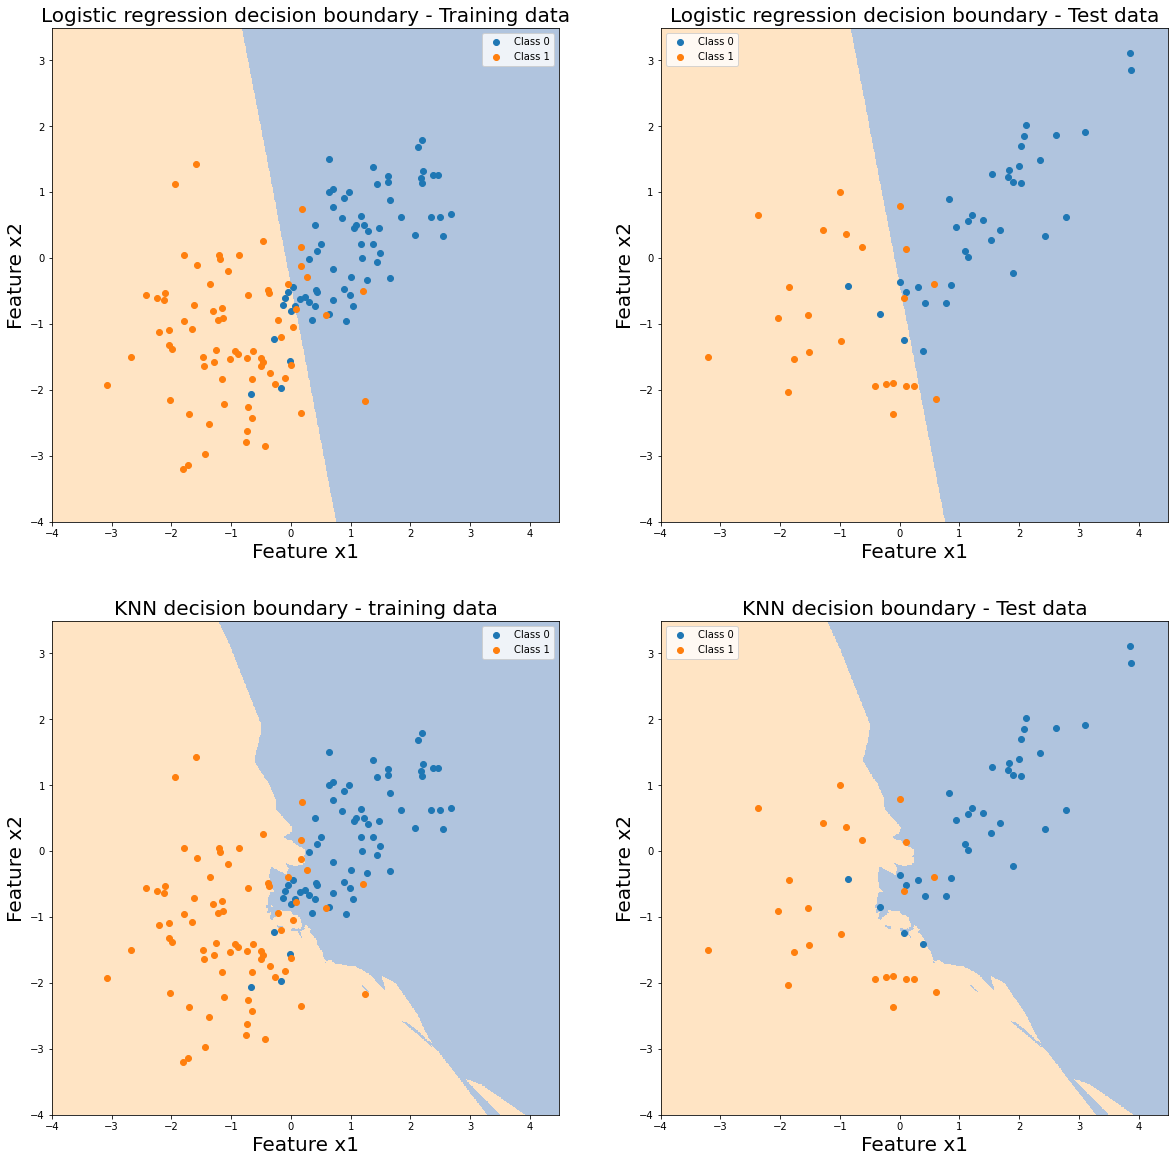

In [ ]:
# Time to plot!
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
cmap = ListedColormap(["lightsteelblue", "bisque"])

# Training data, log_reg
ax[0, 0].pcolormesh(xx, yy, log_reg_grid_predictions, cmap=cmap)
ax[0, 0].scatter(x="x1", y="x2", data=Xy_train_prepped_class_0, label="Class 0")
ax[0, 0].scatter(x="x1", y="x2", data=Xy_train_prepped_class_1, label="Class 1")
ax[0, 0].set_xlabel("Feature x1", fontsize=20)
ax[0, 0].set_ylabel("Feature x2", fontsize=20)
ax[0, 0].set_title("Logistic regression decision boundary - Training data", fontsize = 20)
ax[0, 0].legend()

# Test data, log_reg
ax[0, 1].pcolormesh(xx, yy, log_reg_grid_predictions, cmap=cmap)
ax[0, 1].scatter(x="x1", y="x2", data=Xy_test_prepped_class_0, label="Class 0")
ax[0, 1].scatter(x="x1", y="x2", data=Xy_test_prepped_class_1, label="Class 1")
ax[0, 1].set_xlabel("Feature x1", fontsize=20)
ax[0, 1].set_ylabel("Feature x2", fontsize=20)
ax[0, 1].set_title("Logistic regression decision boundary - Test data", fontsize = 20)
ax[0, 1].legend()

# Training data, knn
ax[1, 0].pcolormesh(xx, yy, knn_grid_predictions, cmap=cmap)
ax[1, 0].scatter(x="x1", y="x2", data=Xy_train_prepped_class_0, label="Class 0")
ax[1, 0].scatter(x="x1", y="x2", data=Xy_train_prepped_class_1, label="Class 1")
ax[1, 0].set_xlabel("Feature x1", fontsize=20)
ax[1, 0].set_ylabel("Feature x2", fontsize=20)
ax[1, 0].set_title("KNN decision boundary - training data", fontsize = 20)
ax[1, 0].legend()

# Test data, knn
ax[1, 1].pcolormesh(xx, yy, knn_grid_predictions, cmap=cmap)
ax[1, 1].scatter(x="x1", y="x2", data=Xy_test_prepped_class_0, label="Class 0")
ax[1, 1].scatter(x="x1", y="x2", data=Xy_test_prepped_class_1, label="Class 1")
ax[1, 1].set_xlabel("Feature x1", fontsize=20)
ax[1, 1].set_ylabel("Feature x2", fontsize=20)
ax[1, 1].set_title("KNN decision boundary - Test data", fontsize = 20)
ax[1, 1].legend();

<font size="4"> As expected, since KNN with K=7 is a more flexible algorithm than logistic regression, the KNN decision boundary is much more nonlinear.

Now let's validate model performance for our logistic regression algorithm and compare it to the KNN model performance.

In [ ]:
log_reg.reset()

In [ ]:
def compute_tpr_fpr(y_hat, y_actual):
    """Find the true positive rate and false positive rate based on binary predictions
    
    Parameters
    ----------
    y_hat: ndarray
        (n x 1) array of binary predictions
    
    y_actual:ndarray
        (n x 1) array of binary labels
    
    Returns
    ----------
    Tuple: (true positive rate, false positive rate)
    """
    
    all_predictions = np.array(y_hat).reshape(-1, 1)
    all_validation_labels = np.array(y_actual).reshape(-1, 1)

    df = pd.DataFrame(data=np.concatenate([all_predictions, all_validation_labels], axis=1),
                         columns = ["y_hat", "y_actual"])

    num_true_pos = df[(df["y_hat"] == 1) & (df["y_actual"] == 1)].shape[0]
    num_true_neg = df[(df["y_hat"] == 0) & (df["y_actual"] == 0)].shape[0]
    num_false_pos = df[(df["y_hat"] == 1) & (df["y_actual"] == 0)].shape[0]
    num_false_neg = df[(df["y_hat"] == 0) & (df["y_actual"] == 1)].shape[0]

    tpr = num_true_pos / (num_true_pos + num_false_neg)
    fpr = num_false_pos / (num_true_neg + num_false_pos)
    
    return tpr, fpr

In [ ]:
def k_folds_cross_validate(model, X, y, k, thresh):
    """Perform k-folds cross validation on a machine learning model
    
    Parameters
    ----------
    model: object
        thre model to evaluate
        
    X: ndarray
        (n x 3) array of observations
    
    y: ndarray
        (n x 1) array of labels corresponding to X
    
    k: int
        number of folds
    
    thresh: double
        model will predict class 1 if prob(class 1 | observation) > thresh 
    
    Returns
    ----------
    true positive rate and false positive rate across all k folds
    """
    
    # Get indices needed to split training data into k folds
    skf = StratifiedKFold(n_splits=k)
    splits = list(skf.split(X, y))
    
    # Store predictions on validation set in an array
    y_hat = []
    # Store actual validation labels in another array
    y_actual = []
    
    for i in range(k):
        # For each fold, use the splits from above to create a training and validation set
        train_mask = np.zeros(len(X), dtype=bool)
        validation_mask = np.zeros(len(X), dtype=bool)
        train_mask[splits[i][0]] = True
        validation_mask[splits[i][1]] = True
        training_features = X[train_mask]
        training_labels = y[train_mask]
        validation_features = X[validation_mask]
        validation_labels = y[validation_mask]
        
        # Fit the model to the training fold
        if (type(model) == Logistic_regression):
            model.fit(training_features, training_labels, np.random.rand(3), lr)
        # else, model is KNN
        else:
            model.fit(training_features, training_labels)
        
        # Make binary predictions on validation set using thresh as decision rule
        if (type(model) == Logistic_regression):
            predictions = model.predict(validation_features, thresh=thresh)
        # else, model is KNN and we need to use predict_proba
        #.  and then for each predication see whether prob(Class 1) > thresh
        else:
            probs = model.predict_proba(validation_features)
            predictions = np.zeros(probs.shape[0])
            for j in range(probs.shape[0]):
                if probs[j][1] >= thresh:
                    # If we don't include the following if statement,
                    #.  ROC curve for KNN won't touch (0, 0)
                    if (thresh != 1):
                        predictions[j] = 1
                    
        # Save predictions and labels
        y_hat.append(predictions)
        y_actual.append(validation_labels)
        
        # Reset the model so we can train it again fresh on the next loop
        if (type(model) == Logistic_regression):
            model.reset()
    
    # Return the combined true positive rate and false positive rate for all k folds
    return compute_tpr_fpr(y_hat, y_actual)

In [ ]:
def ROC_curve_helper(num_threshholds, model, X, y, k):
    """Evaluate model using cross validation with k folds
    and get a dataframe with tpr and fpr across all k folds
    for each threshhold
    
    Parameters
    ----------
    num_threshholds: int
        number of points you want on the ROC curve
    
    model: object
        the model to plot an ROC curve for
        
    X: ndarray
        (n x 3) matric of observations
        
    y: ndarray
        (n x 1) array of labels for X
    
    k: int
        number of folds in k-folds cross validation
    
    Returns
    ----------
    Pandas dataframe with true positive rate and false positive rate
    (across all k folds) for every threshhold
    """
    
    ans = pd.DataFrame(index=range(num_threshholds), columns=["thresh", "tpr", "fpr"])
    threshholds = np.linspace(0, 1, num_threshholds)
    for i in range(num_threshholds):
        tpr, fpr = k_folds_cross_validate(model, X, y, k, threshholds[i])
        ans.iloc[i]["thresh"] = threshholds[i]
        ans.iloc[i]["tpr"] = tpr
        ans.iloc[i]["fpr"] = fpr
    return ans

In [ ]:
ROC_df_log_reg = ROC_curve_helper(500, log_reg, X_train_prepped, y_train.to_numpy(), 10)
ROC_df_knn = ROC_curve_helper(500, knn, X_train_prepped, y_train.to_numpy().ravel(), 10)

area_under_ROC_log_reg = round(-np.trapz(ROC_df_log_reg["tpr"], x=ROC_df_log_reg["fpr"]), 3)
area_under_ROC_knn = round(-np.trapz(ROC_df_knn["tpr"], x=ROC_df_knn["fpr"]), 3)

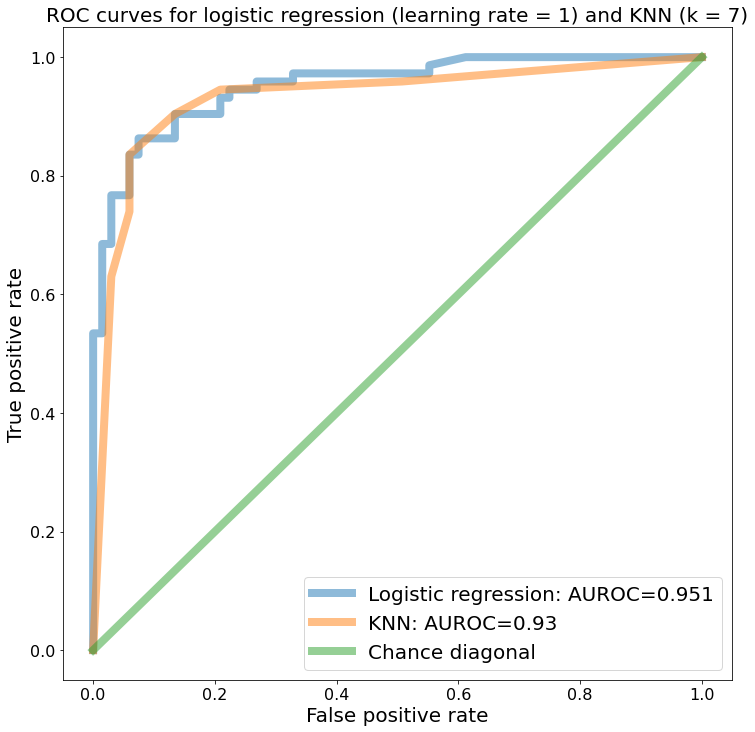

In [ ]:
plt.figure(figsize=(12, 12))
plt.title("ROC curves for logistic regression (learning rate = 1) and KNN (k = 7)",
          fontsize=20);
plt.plot(ROC_df_log_reg["fpr"], ROC_df_log_reg["tpr"],
         label=f"Logistic regression: AUROC={area_under_ROC_log_reg}",
         linewidth=8, alpha=0.5);
plt.plot(ROC_df_knn["fpr"], ROC_df_knn["tpr"],
         label=f"KNN: AUROC={area_under_ROC_knn}", linewidth=8, alpha=0.5);
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100),
         label="Chance diagonal",linewidth=8, alpha=0.5);
plt.xlabel("False positive rate", fontsize=20)
plt.ylabel("True positive rate", fontsize=20)
plt.xticks(fontsize="16")
plt.yticks(fontsize="16")
plt.legend(prop={"size": 20});

In [ ]:
percent_diff_AUROC = round(100 * (area_under_ROC_log_reg / area_under_ROC_knn), 3)

print(f"The AUROC for logistic regression is {percent_diff_AUROC}% of the AUROC for KNN.")

The AUROC for logistic regression is 102.258% of the AUROC for KNN.


<font size="4">Why do we use cross validation in this example? Although our dataset isn't terribly small (n=140), it's still fairly modestly sized. Using k-folds cross validation allows us to get a more accurate prediction of model generalization performance compared to just training once on the training data and evaluating on the test data. Cross validation effectively increases the size of our test set. Also, since KNN and logistic regression are not very computationally intensive, we can afford to run k-folds cross validation... so why not!

----------------------------------------------------------------------------------------------------

<font size="4">Choosing a model: I would go with logistic regression in this case. The area under the ROC curve is greater than that of KNN, and logistic regression is lower-variance than KNN. We can see this from the linearity of the decision boundary for logistic regression and the non-linearity of the KNN decision boundary.

# Section 2: Digits classification


<font size="4"> The goal of this section is to classify digits from the MNIST dataset as either belonging to the category "3" or "not a 3."

<font size="4"> Code in the cell immediately below was provided by the instructor.

In [ ]:
# Load the MNIST Data
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pickle

# Set this to True to download the data for the first time and False after the first time 
#   so that you just load the data locally instead
download_data = True

if download_data:
    # Load data from https://www.openml.org/d/554
    X, y = fetch_openml('mnist_784', return_X_y=True, as_frame=False)
    
    # Adjust the labels to be '1' if y==3, and '0' otherwise
    y[y!='3'] = 0
    y[y=='3'] = 1
    y = y.astype('int')
    
    # Divide the data into a training and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=88)
    
    file = open('tmpdata', 'wb')
    pickle.dump((X_train, X_test, y_train, y_test), file)
    file.close()
else:
    file = open('tmpdata', 'rb')
    X_train, X_test, y_train, y_test = pickle.load(file)
    file.close()

### (a) Visualize the data

In [ ]:
# Convert training and test data to dataframes
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train, columns=["y"])
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test, columns = ["y"])

# Pair observations with labels
Xy_train = pd.concat([X_train, y_train], axis=1)
Xy_test = pd.concat([X_test, y_test], axis=1)

# Separate labeled observations by class
Xy_train_class_0 = Xy_train[Xy_train["y"] == 0]
Xy_train_class_1 = Xy_train[Xy_train["y"] == 1]

# Pull the labels off of the separated classes
X_train_class_0 = Xy_train_class_0.drop(["y"], axis=1)
X_train_class_1 = Xy_train_class_1.drop(["y"], axis=1)

In [ ]:
# Get ten samples from each class, reshaped into 28 x 28 arrays
class_0_samples = []
class_1_samples = []

for i in range(10):
    class_0_sample = X_train_class_0.iloc[i].to_numpy().reshape(28, -1)
    class_1_sample = X_train_class_1.iloc[i].to_numpy().reshape(28, -1)
    class_0_samples.append(class_0_sample)
    class_1_samples.append(class_1_sample)

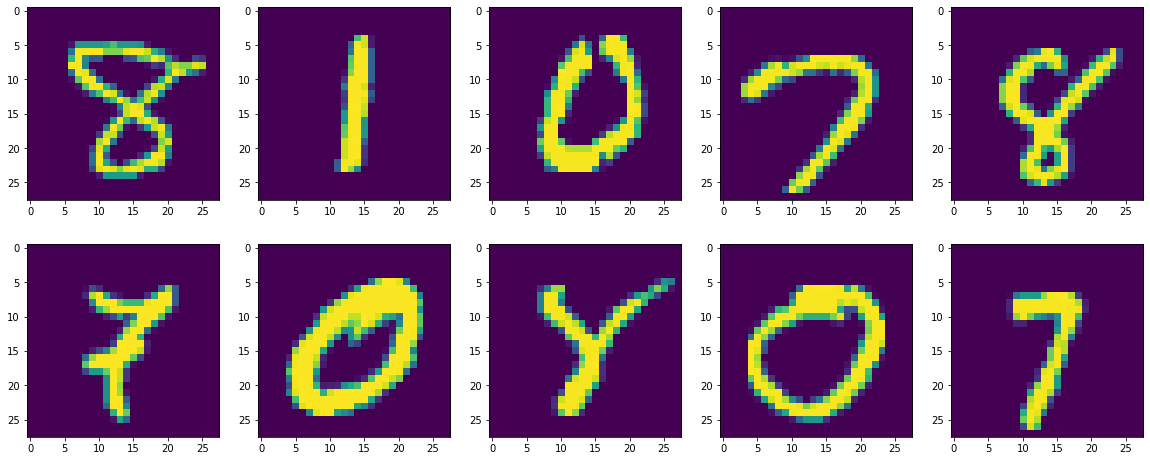

In [ ]:
# Plot data from class 0
fig, ax = plt.subplots(2, 5, figsize=(20, 8))

ax[0, 0].imshow(class_0_samples[0]);
ax[0, 1].imshow(class_0_samples[1]);
ax[0, 2].imshow(class_0_samples[2]);
ax[0, 3].imshow(class_0_samples[3]);
ax[0, 4].imshow(class_0_samples[4]);
ax[1, 0].imshow(class_0_samples[5]);
ax[1, 1].imshow(class_0_samples[6]);
ax[1, 2].imshow(class_0_samples[7]);
ax[1, 3].imshow(class_0_samples[8]);
ax[1, 4].imshow(class_0_samples[9]);

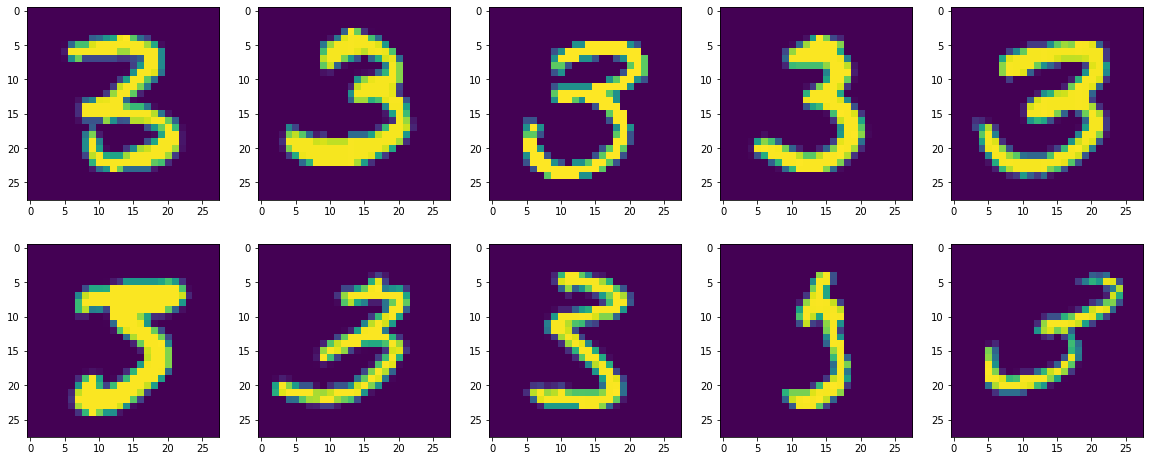

In [ ]:
# Plot data from class 1
fig, ax = plt.subplots(2, 5, figsize=(20, 8))

ax[0, 0].imshow(class_1_samples[0]);
ax[0, 1].imshow(class_1_samples[1]);
ax[0, 2].imshow(class_1_samples[2]);
ax[0, 3].imshow(class_1_samples[3]);
ax[0, 4].imshow(class_1_samples[4]);
ax[1, 0].imshow(class_1_samples[5]);
ax[1, 1].imshow(class_1_samples[6]);
ax[1, 2].imshow(class_1_samples[7]);
ax[1, 3].imshow(class_1_samples[8]);
ax[1, 4].imshow(class_1_samples[9]);

### (b) Is this an imbalanced classification problem?

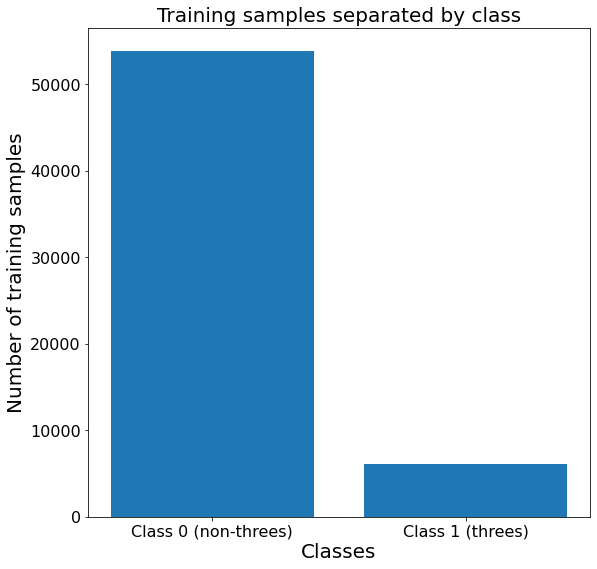

In [ ]:
train_num_nonthrees = len(X_train_class_0)
train_num_threes = len(X_train_class_1)

plt.figure(figsize=(9, 9))
plt.title("Training samples separated by class", fontsize=20)
plt.xlabel("Classes", fontsize=20)
plt.ylabel("Number of training samples", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.bar(["Class 0 (non-threes)", "Class 1 (threes)"],
        [train_num_nonthrees, train_num_threes]);

In [ ]:
frac_threes = train_num_threes / (train_num_threes + train_num_nonthrees)

print(f"The fraction of threes in the training data is {frac_threes}, approximately 10%.")

The fraction of threes in the training data is 0.10215, approximately 10%.


<font size="4">This imbalance in training data could present a problem if we were to use a generative model (which models the likelihood). A generative model has to come up with a prior. How does it do this? Usually, it generates the prior based on the empirical distribution of the training data. Since class 1 observations and much less common than class 0 observations in the training data, the model would likely form the prior belief that this is how the data are distributed outside of the training set (and use that prior along with its model of the likelihood to compute the posterior). If the balance of class representation in the training set is very different from the balance of data in the test set (or if both the training and test sets have a much different composition compared to data in the wild), the model could be way off.

### (c) Tune the regularization parameter to achieve optimal test performance

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

In [ ]:
C_vals = np.logspace(-4, 4, 20)

nums_nonzero_params = []
log_losses = []
AUROCs = []
F1s = []

for C in C_vals:
    # Fit a model to the data using lasso regularization
    model = LogisticRegression(penalty="l1", solver="liblinear", C=C)
    model.fit(X_train.to_numpy(), y_train.to_numpy().ravel())
    
    # Find number of nonzero model coefficients
    coef = model.coef_
    nonzero_coef = coef[coef != 0]
    nums_nonzero_params.append(nonzero_coef.shape[0])
    
    # Compute log loss
    y_hat = model.predict(X_test.to_numpy())
    log_losses.append(log_loss(y_test.to_numpy().ravel(), y_hat))
    
    # Compute AUROC
    y_hat_proba = model.predict_proba(X_test.to_numpy())[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test.to_numpy().ravel(), y_hat_proba)
    AUROC = np.trapz(tpr, x=fpr)
    AUROCs.append(AUROC)
    
    # Compute F1-score
    F1 = f1_score(y_test.to_numpy().ravel(), y_hat)
    F1s.append(F1)

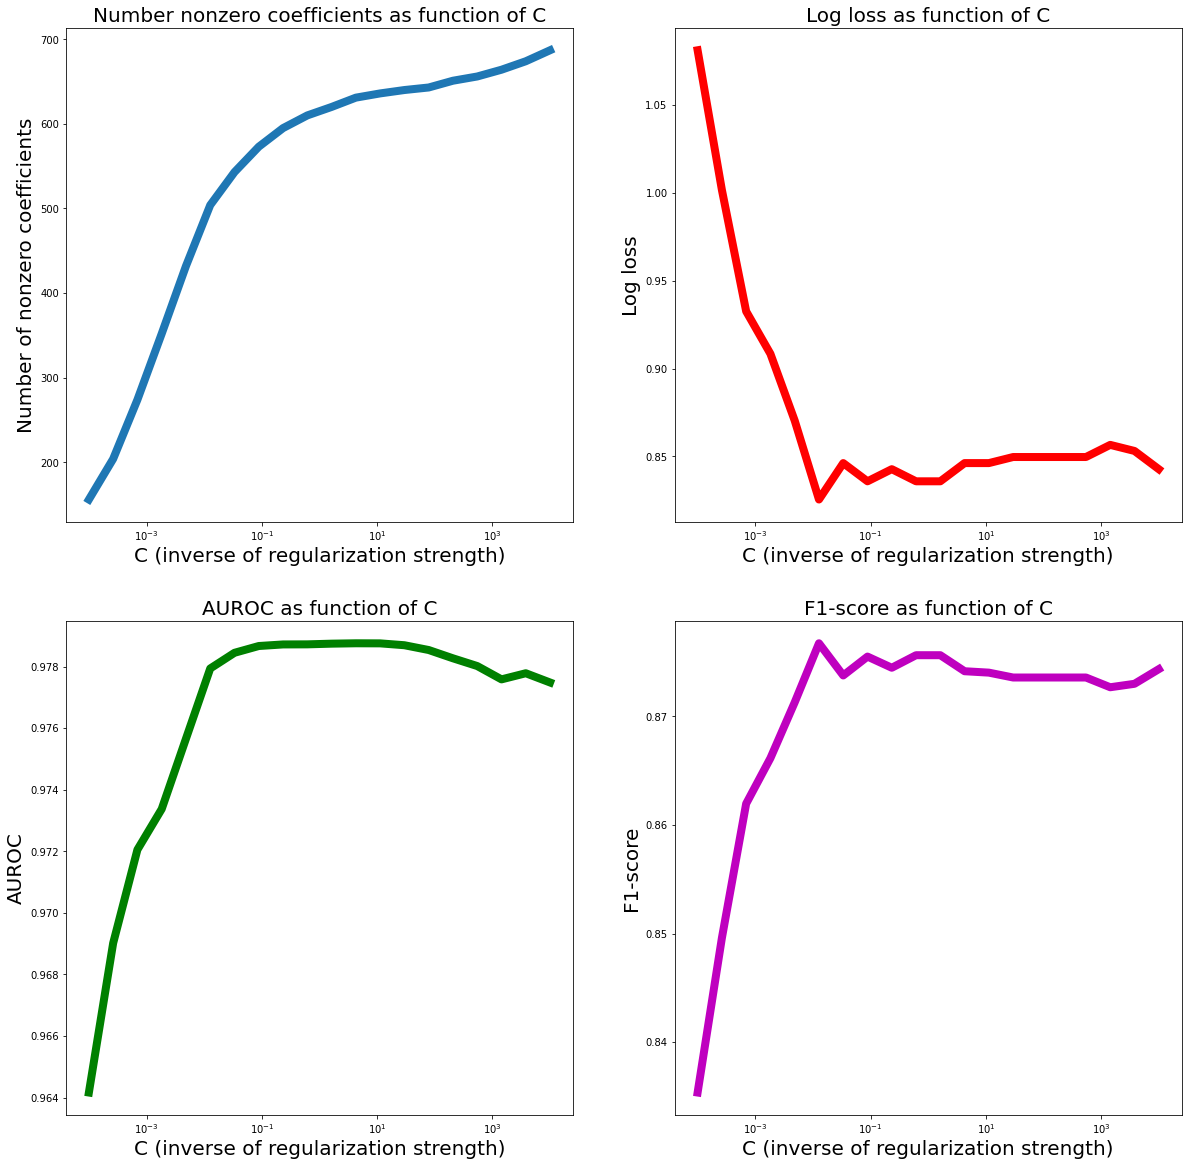

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

ax[0, 0].set_xscale("log")
ax[0, 0].set_title("Number nonzero coefficients as function of C", fontsize=20)
ax[0, 0].set_xlabel("C (inverse of regularization strength)", fontsize=20)
ax[0, 0].set_ylabel("Number of nonzero coefficients", fontsize=20)
ax[0, 0].plot(C_vals, nums_nonzero_params, linewidth=8);

ax[0, 1].set_xscale("log")
ax[0, 1].set_title("Log loss as function of C", fontsize=20)
ax[0, 1].set_xlabel("C (inverse of regularization strength)", fontsize=20)
ax[0, 1].set_ylabel("Log loss", fontsize=20)
ax[0, 1].plot(C_vals, log_losses, linewidth=8, color='r');

ax[1, 0].set_xscale("log")
ax[1, 0].set_title("AUROC as function of C", fontsize=20)
ax[1, 0].set_xlabel("C (inverse of regularization strength)", fontsize=20)
ax[1, 0].set_ylabel("AUROC", fontsize=20)
ax[1, 0].plot(C_vals, AUROCs, linewidth=8, color='g');

ax[1, 1].set_xscale("log")
ax[1, 1].set_title("F1-score as function of C", fontsize=20)
ax[1, 1].set_xlabel("C (inverse of regularization strength)", fontsize=20)
ax[1, 1].set_ylabel("F1-score", fontsize=20)
ax[1, 1].plot(C_vals, F1s, linewidth=8, color='m');

<font size="4"> A C-value of 10e-1 appears to result in the best model performance. The AUROC is high for this value of C and doesn't get any higher for other values of C. For F1-score and log loss, model performance is best at C = 10e-1. 

### (d) Compare the performance of four different models:
     (1) scikit-learns logistic regression model with very little regularization

     (2) our tuned logistic regression model

     (3) scikit-learn's out-of-the-box random forest classifier

     (4) sci-kit learn's out-of-the-box linear discriminant analysis (LDA) model

In [ ]:
log_reg_unregularized = LogisticRegression(penalty="l1", solver="liblinear", C=1e100)
log_reg_optimal_reg = LogisticRegression(penalty="l1", solver="liblinear", C=10e-1)
lda = LinearDiscriminantAnalysis()
rand_forest = RandomForestClassifier()

log_reg_unregularized.fit(X_train.to_numpy(), y_train.to_numpy().ravel())
log_reg_optimal_reg.fit(X_train.to_numpy(), y_train.to_numpy().ravel())
lda.fit(X_train.to_numpy(), y_train.to_numpy().ravel())
rand_forest.fit(X_train.to_numpy(), y_train.to_numpy().ravel())

y_hat_a = log_reg_unregularized.predict_proba(X_test.to_numpy())[:,1]
y_hat_b = log_reg_optimal_reg.predict_proba(X_test.to_numpy())[:,1]
y_hat_c = lda.predict_proba(X_test.to_numpy())[:,1]
y_hat_d = rand_forest.predict_proba(X_test.to_numpy())[:,1]

fpr_a, tpr_a, _ = roc_curve(y_test.to_numpy().ravel(), y_hat_a)
fpr_b, tpr_b, _ = roc_curve(y_test.to_numpy().ravel(), y_hat_b)
fpr_c, tpr_c, _ = roc_curve(y_test.to_numpy().ravel(), y_hat_c)
fpr_d, tpr_d, _ = roc_curve(y_test.to_numpy().ravel(), y_hat_d)

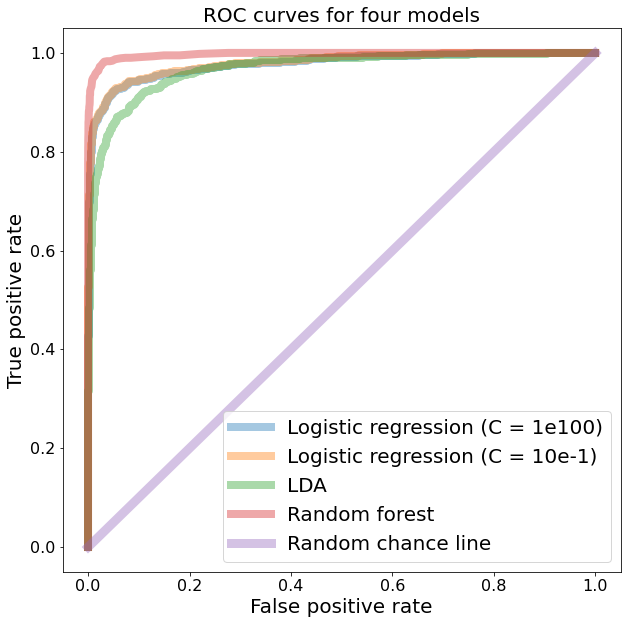

In [ ]:
plt.figure(figsize=(10, 10))
plt.title("ROC curves for four models", fontsize=20)
plt.xlabel("False positive rate", fontsize=20)
plt.ylabel("True positive rate", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(fpr_a, tpr_a, alpha=0.4, linewidth=8, label="Logistic regression (C = 1e100)");
plt.plot(fpr_b, tpr_b, alpha=0.4, linewidth=8, label="Logistic regression (C = 10e-1)");
plt.plot(fpr_c, tpr_c, alpha=0.4, linewidth=8, label="LDA");
plt.plot(fpr_d, tpr_d, alpha=0.4, linewidth=8, label="Random forest");
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), alpha=0.4, linewidth=9, label="Random chance line")
plt.legend(prop={"size":20});

In [ ]:
from sklearn.metrics import precision_recall_curve

In [ ]:
num_test_class_1 = Xy_test[Xy_test["y"] == 1].shape[0]
pct_test_class_1 = num_test_class_1 / Xy_test.shape[0]

In [ ]:
precision_a, recall_a, _ = precision_recall_curve(y_test.to_numpy().ravel(), y_hat_a)
precision_b, recall_b, _ = precision_recall_curve(y_test.to_numpy().ravel(), y_hat_b)
precision_c, recall_c, _ = precision_recall_curve(y_test.to_numpy().ravel(), y_hat_c)
precision_d, recall_d, _ = precision_recall_curve(y_test.to_numpy().ravel(), y_hat_d)

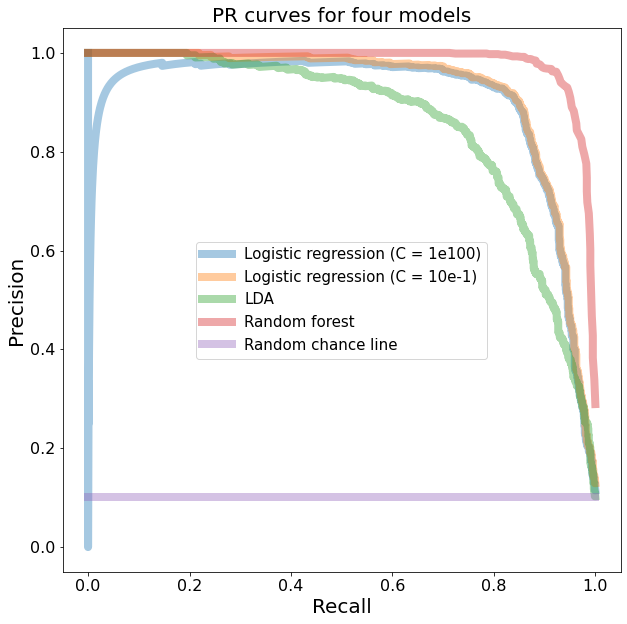

In [ ]:
plt.figure(figsize=(10, 10))
plt.title("PR curves for four models", fontsize=20)
plt.xlabel("Recall", fontsize=20)
plt.ylabel("Precision", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(recall_a, precision_a, label="Logistic regression (C = 1e100)", linewidth=8, alpha=0.4);
plt.plot(recall_b, precision_b, label="Logistic regression (C = 10e-1)", linewidth=8, alpha=0.4);
plt.plot(recall_c, precision_c, label="LDA", linewidth=8, alpha=0.4);
plt.plot(recall_d, precision_d, label="Random forest", linewidth=8, alpha=0.4);
plt.plot(np.linspace(0, 1, 100), pct_test_class_1 * np.ones(100),alpha=0.4, label="Random chance line", linewidth=8)
plt.legend(prop={"size":15});

<font size="4"> Out of all four models, I would choose the random forest. It's ROC and PR curves best approximate the optimal ROC and PR curves.

<font size="4"> LDA is the worst-performing algorithm of the bunch. Since LDA assumes that the likelihood for each class follows a Guassian distribution, I suspect that for at least one class, the likelihood is far from normal.

<font size="4"> The choice of C doesn't seem to make much of a difference for this problem. The ROC curves of the two logistic regression models are right on top of one another, and their PR curves are mostly on top of one another as well. The one difference is that the PR curve for the model that is very unregularized dips well-below the random chance line in one region of the graph. For this reason, I would go with the regularized model if I had to pick one of the linear regression models.